In [1]:
import numpy as np
import matplotlib.pyplot as plt
sig = np.load('tests/testing_data/signal.npy')
sig.shape
%matplotlib inline

In [2]:
from monai.transforms import SignalResample
from monai.transforms import SignalRandShift
from monai.transforms import Compose

/Users/doursand/opt/anaconda3/envs/monai/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
tfs = Compose([SignalResample(method='polynomial',current_sample_rate=500,target_sample_rate=250),
               SignalRandShift()])

In [4]:
tfs(sig).shape

(6, 1000)

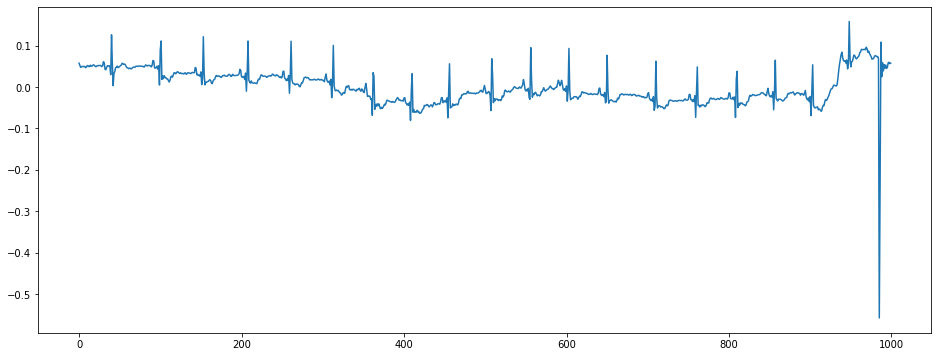

In [6]:
plt.figure(figsize=(16,6))
plt.plot(tfs(sig)[0,:])